In [1]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import sklearn.metrics as m

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# SqueezeNet

In [4]:
data = np.load('../data/data.npy')
labels = np.load('../data/labels.npy')

[0 0 1]


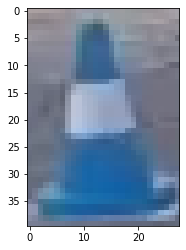

In [5]:
print(labels[1])
plt.imshow(data[1])

In [6]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, train_size=0.8, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, train_size=0.5, shuffle=True)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4000, 40, 28, 3),
 (4000, 3),
 (500, 40, 28, 3),
 (500, 3),
 (500, 40, 28, 3),
 (500, 3))

In [7]:
def fire(x: tf.Tensor, squeeze: int, expand: int, bnmomemtum: float) -> tf.Tensor:
    y = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])


def fire_module(squeeze: int, expand: int, bnmomemtum: float) -> tf.Tensor:
    return lambda x: fire(x, squeeze, expand, bnmomemtum)

In [8]:
batch_size = 64
nb_epoch = 50
img_rows, img_cols, channels = 40, 28, 3
classes = 3
bnmomemtum = 0.9

x = tf.keras.layers.Input(shape=[img_rows, img_cols, channels])

y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48, bnmomemtum)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96, bnmomemtum)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128, bnmomemtum)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96, bnmomemtum)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48, bnmomemtum)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(classes, activation='softmax')(y)

model = tf.keras.Model(x, y)

model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('logs', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.TensorBoard()
]

In [9]:
# model.summary()

In [10]:
h = model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 13s 116ms/step - loss: 0.4116 - accuracy: 0.8483 - precision: 0.8729 - recall: 0.8008 - val_loss: 0.0224 - val_accuracy: 0.9980 - val_precision: 1.0000 - val_recall: 0.9980
INFO:tensorflow:Assets written to: logs/assets
Epoch 2/50
63/63 [==============================] - 4s 67ms/step - loss: 0.0334 - accuracy: 0.9943 - precision: 0.9948 - recall: 0.9927 - val_loss: 0.0983 - val_accuracy: 0.9800 - val_precision: 0.9839 - val_recall: 0.9780
Epoch 3/50
63/63 [==============================] - 4s 66ms/step - loss: 0.0363 - accuracy: 0.9951 - precision: 0.9954 - recall: 0.9943 - val_loss: 0.0318 - val_accuracy: 0.9940 - val_precision: 0.9960 - val_recall: 0.9940
Epoch 4/50
63/63 [==============================] - 4s 67ms/step - loss: 0.0309 - accuracy: 0.9948 - precision: 0.9949 - recall: 0.9940 - val_loss: 0.0293 - val_accuracy: 0.9940 - val_precision: 0.9940 - val_recall: 0.9940
Epoch 5/50
63/63 [==============================] - 4s 66ms

In [11]:
model.evaluate(X_train, y_train)
model.evaluate(X_val, y_val)
model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 11ms/step - loss: 0.0262 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920


[0.02615700475871563,
 0.9919999837875366,
 0.9919999837875366,
 0.9919999837875366]

In [12]:
model.evaluate(X_test[np.where(y_test[:,0] == 1)], y_test[np.where(y_test[:,0] == 1)])
model.evaluate(X_test[np.where(y_test[:,1] == 1)], y_test[np.where(y_test[:,1] == 1)])
model.evaluate(X_test[np.where(y_test[:,2] == 1)], y_test[np.where(y_test[:,2] == 1)])

7/7 [==============================] - 1s 90ms/step - loss: 0.0445 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862


[0.044517822563648224,
 0.9862385392189026,
 0.9862385392189026,
 0.9862385392189026]

In [13]:
preds = model.predict(X_test)
labels = np.argmax(preds, axis=1)
gt_labels = np.argmax(y_test, axis=1)

In [15]:
f1_score(gt_labels, labels, average='weighted')

0.9919958506401199

In [17]:
# model.save('../models/color_model')